In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lattice_afi import lattice_2d
from krylov_trotter_circuits import HeavyHexHeisenbergKrylovTNSim
import numpy as np
from scipy.sparse import kron as spkron
from scipy.sparse.linalg import expm as sp_expm
from scipy.linalg import toeplitz
# from krylov_ED.ED_Kylov_trotter import solve_regularized_gen_eig

In [4]:
import scipy as sp
import itertools as it
from qiskit.quantum_info import Pauli

def solve_regularized_gen_eig(h, s, k=1, threshold=1e-15, return_vecs=False):

    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = [vec for val, vec in zip(s_vals, s_vecs) if val > threshold]
    if not good_vecs:
        raise AssertionError('WHOLE SUBSPACE ILL-CONDITIONED')
    good_vecs = np.array(good_vecs).T

    h_reg = good_vecs.conj().T @ h @ good_vecs
    s_reg = good_vecs.conj().T @ s @ good_vecs
    vals, vecs = sp.linalg.eigh(h_reg, s_reg)
    if return_vecs:
        return vals[0:k], good_vecs @ vecs[:,0:k]
    else:
        return vals[0:k]
    
def single_particle_gs(H_op, n_qubits):
    H_x = []
    for p, coeff in H_op.to_list():
        H_x.append(set([i for i,v in enumerate(Pauli(p).x) if v]))

    H_z = []
    for p, coeff in H_op.to_list():
        H_z.append(set([i for i,v in enumerate(Pauli(p).z) if v]))

    H_c = H_op.coeffs

    print('n_sys_qubits', n_qubits)

    # n_exc particle Hamiltonian:

    n_exc = 1
    sub_dimn = int(sp.special.comb(n_qubits+1,n_exc))
    print('n_exc', n_exc, ', subspace dimension', sub_dimn)

    few_particle_H = np.zeros((sub_dimn,sub_dimn), dtype=complex)

    sparse_vecs = [set(vec) for vec in it.combinations(range(n_qubits+1),r=n_exc)] # list all of the possible sets of n_exc indices of 1s in n_exc-particle states

    m = 0
    for i, i_set in enumerate(sparse_vecs):
        for j, j_set in enumerate(sparse_vecs):
            m += 1
            # if m % int((sub_dimn**2)/100) == 0:
            #     print(np.round(m/int((sub_dimn**2)/100),2), '% complete, time =', time.time()-start_time)
            #     start_time = time.time()

            if len(i_set.symmetric_difference(j_set)) <= 2:

                for p_x, p_z, coeff in zip(H_x, H_z, H_c):

                    if i_set.symmetric_difference(j_set) == p_x:
                        sgn = ((-1j)**len(p_x.intersection(p_z)))*((-1)**len(i_set.intersection(p_z)))
                    else:
                        sgn = 0

                    few_particle_H[i,j] += sgn*coeff

    gs_en = min(np.linalg.eigvalsh(few_particle_H))
    print('single particle ground state energy: ', gs_en)
    return gs_en


# def krylov_diagonalization(Hkrylov, Skrylov, k=1, initial_threshold = 1e-15):
#     success = False
#     threshold = initial_threshold
#     count = 0
#     while not success and count < 16:
#         try:
#             evals = solve_regularized_gen_eig(Hkrylov, Skrylov, threshold=threshold, k=k)
#             success = True
#         except:
#             threshold *= 10
#             count += 1
#     if not success:
#         print('Did not converge')
#     return evals, threshold

# def spectral_norm(H):
#     sing_max = -np.inf
#     for h in H:
#         u,s,vh = np.linalg.svd(h.toarray(), full_matrices=False)
#         if max(s) > sing_max:
#             sing_max = max(s)
#     return sing_max

## Small system example

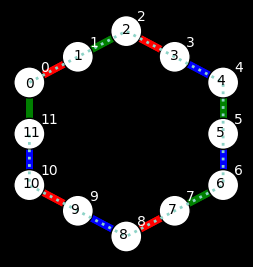

In [5]:
#Example lattice
n_qubits = 12
mps_order = np.arange(n_qubits) #Do not need to set manually always. The default is optimized for a 2D heavy-hex lattice. 
                        #In this example, we consider a single plaquette so that the TN numerics can be benchmarked against exact calculations.
lat = lattice_2d(nx=1,ny=1, mps_order=mps_order) #Initialize lattice
lat.draw(show_gates=True, show_mps_order=True, enumerate_qubits=True)

In [6]:
edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1]]
l1_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==1]
l2_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==2]
l3_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==3]
colored_edges = [l1_edges, l2_edges, l3_edges]

In [7]:
#Krylov algorithms parameters

dt = 0.1
trotter_order = 6
krylov_dim = 10

J = 1.0
g = -1.0

particle_inds = [int(n_qubits/2)]

In [59]:
from qiskit.quantum_info import SparsePauliOp
# Define the Hamiltonian: 
H_int = [['I']*n_qubits for _ in range(3*(n_qubits))]
for i in range(n_qubits-1):
    H_int[i][i] = 'Z'
    H_int[i][i+1] = 'Z'
# boundary conditions
H_int[n_qubits-1][0] = 'Z'
H_int[n_qubits-1][-1] = 'Z'

for i in range(n_qubits-1):
    H_int[n_qubits+i][i] = 'X'
    H_int[n_qubits+i][i+1] = 'X'
# boundary conditions
H_int[2*n_qubits-1][0] = 'X'
H_int[2*n_qubits-1][-1] = 'X'

for i in range(n_qubits-1):
    H_int[2*(n_qubits)+i][i] = 'Y'
    H_int[2*(n_qubits)+i][i+1] = 'Y'
# boundary conditions
H_int[3*n_qubits-1][0] = 'Y'
H_int[3*n_qubits-1][-1] = 'Y'


H_int = [''.join(term) for term in H_int]
H_tot = [(term, g) if term.count('Z') == 2 else (term, 1) for term in H_int]

# Get operator
H_op = SparsePauliOp.from_list(H_tot)
print(H_tot)

[('ZZIIIIIIIIII', -1.0), ('IZZIIIIIIIII', -1.0), ('IIZZIIIIIIII', -1.0), ('IIIZZIIIIIII', -1.0), ('IIIIZZIIIIII', -1.0), ('IIIIIZZIIIII', -1.0), ('IIIIIIZZIIII', -1.0), ('IIIIIIIZZIII', -1.0), ('IIIIIIIIZZII', -1.0), ('IIIIIIIIIZZI', -1.0), ('IIIIIIIIIIZZ', -1.0), ('ZIIIIIIIIIIZ', -1.0), ('XXIIIIIIIIII', 1), ('IXXIIIIIIIII', 1), ('IIXXIIIIIIII', 1), ('IIIXXIIIIIII', 1), ('IIIIXXIIIIII', 1), ('IIIIIXXIIIII', 1), ('IIIIIIXXIIII', 1), ('IIIIIIIXXIII', 1), ('IIIIIIIIXXII', 1), ('IIIIIIIIIXXI', 1), ('IIIIIIIIIIXX', 1), ('XIIIIIIIIIIX', 1), ('YYIIIIIIIIII', 1), ('IYYIIIIIIIII', 1), ('IIYYIIIIIIII', 1), ('IIIYYIIIIIII', 1), ('IIIIYYIIIIII', 1), ('IIIIIYYIIIII', 1), ('IIIIIIYYIIII', 1), ('IIIIIIIYYIII', 1), ('IIIIIIIIYYII', 1), ('IIIIIIIIIYYI', 1), ('IIIIIIIIIIYY', 1), ('YIIIIIIIIIIY', 1)]


In [9]:
tn_circ = HeavyHexHeisenbergKrylovTNSim(lat.nx, lat.ny, chi_max=64, J=J, g=g, mps_order=mps_order) #change lat.nx and lat.ny appropriately. chi_max is maximum bond dimension
tn_circ.initialize_state(flip_inds=particle_inds) #lattice site indices to populate with a particle
S_tn = tn_circ.krylov_S(krylov_dim=krylov_dim, dt=dt, trotter_order=trotter_order) #Build H and S matrices
H_tn = tn_circ.krylov_H(krylov_dim=krylov_dim, dt=dt, trotter_order=trotter_order)

In [10]:
gs_en = single_particle_gs(H_op, n_qubits)
gs_en

n_sys_qubits 12
n_exc 1 , subspace dimension 13
single particle ground state energy:  -12.0


-12.0

In [11]:
gs_en = min(sp.sparse.linalg.eigsh(H_op.to_matrix(), which = "SA", k = 10)[0])
print('gs_en', gs_en)

gs_en -12.0


In [12]:
gnd_en_tn_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_tn_est = solve_regularized_gen_eig(H_tn[:d, :d], S_tn[:d, :d], threshold=0.01)
    gnd_en_tn_list.append(gnd_en_tn_est)
    print('The estimated ground state energy is: ', gnd_en_tn_est)

The estimated ground state energy is:  [-8.]
The estimated ground state energy is:  [-10.97433249]
The estimated ground state energy is:  [-10.85630435]
The estimated ground state energy is:  [-10.78939815]
The estimated ground state energy is:  [-12.03396083]
The estimated ground state energy is:  [-11.72549117]
The estimated ground state energy is:  [-11.59378095]
The estimated ground state energy is:  [-11.51311332]
The estimated ground state energy is:  [-11.45161761]
The estimated ground state energy is:  [-12.77684121]


In [13]:
assert np.isclose(H_tn,H_tn.conj().T).all() and np.isclose(S_tn,S_tn.conj().T).all() #check Hermiticity

In [14]:
from sympy import Matrix
Matrix(H_tn)

Matrix([
[                                    -8.0,   -6.76002500705942 - 3.70758060272874*I,   -3.64572326884841 - 5.86319546377357*I, -0.0867222375839577 - 5.69184217701127*I,      2.365825007186 - 3.53861514294145*I,   2.80536239352259 - 0.645059908998737*I,    1.37597015241079 + 1.52139681086316*I,  -0.880651615522959 + 2.01816677747248*I,  -2.63187686617433 + 0.860875870887451*I,    -2.97075361801023 - 1.0729506127369*I],
[  -6.76002500705942 + 3.70758060272874*I,                                     -8.0,   -6.76002500705942 - 3.70758060272874*I,   -3.64572326884841 - 5.86319546377357*I, -0.0867222375839577 - 5.69184217701127*I,      2.365825007186 - 3.53861514294145*I,   2.80536239352259 - 0.645059908998737*I,    1.37597015241079 + 1.52139681086316*I,  -0.880651615522959 + 2.01816677747248*I,  -2.63187686617433 + 0.860875870887451*I],
[  -3.64572326884841 + 5.86319546377357*I,   -6.76002500705942 + 3.70758060272874*I,                                     -8.0,   -6.76002500705942 

In [15]:
Matrix(S_tn)

Matrix([
[                                         1.0,       0.884588711863563 + 0.37399810874824*I,       0.589623860133516 + 0.60709946055033*I,       0.243200848591149 + 0.62554945720666*I, -0.0132989154722969 + 0.455255559113775*I, -0.0931986358860056 + 0.203642734499086*I, -0.00190803438640065 + 0.00174778630008298*I,     0.174261537315216 - 0.0619551769165379*I,     0.319551838193273 + 0.0186854203461947*I,      0.351244969828422 + 0.173327678813287*I],
[      0.884588711863563 - 0.37399810874824*I,                                          1.0,       0.884588711863563 + 0.37399810874824*I,       0.589623860133516 + 0.60709946055033*I,    0.243200848591149 + 0.62554945720666*I, -0.0132989154722969 + 0.455255559113775*I,    -0.0931986358860056 + 0.203642734499086*I, -0.00190803438640065 + 0.00174778630008298*I,     0.174261537315216 - 0.0619551769165379*I,     0.319551838193273 + 0.0186854203461947*I],
[      0.589623860133516 - 0.60709946055033*I,       0.884588711863563 - 0.3739

In [43]:
res_dict_tn = {i : {} for i in range(krylov_dim-1)}
for obs in observables_S + observables_H:
    obs_str = obs[0]
    sys_obs = obs_str[:-1]
    anc_obs = obs_str[-1]

    for i in range(krylov_dim-1):
        tn_circ.state = tn_circ.pre_measure_states[i].copy()
        tn_circ.apply_controlled_state_prep(control_val=0)


        res_dict_tn[i][obs_str] = tn_circ.meas_hadamard_test(sys_obs, ancilla_op = anc_obs)


## Noiseless circuit simulator

In [16]:
sys_colored_edges = [[(pair[0]-1, pair[1]-1) for pair in layer] for layer in colored_edges]
sys_colored_edges

[[(3, 4), (5, 6), (8, 9), (10, 11)],
 [(1, 2), (4, 5), (6, 7), (0, 11)],
 [(0, 1), (2, 3), (7, 8), (9, 10)]]

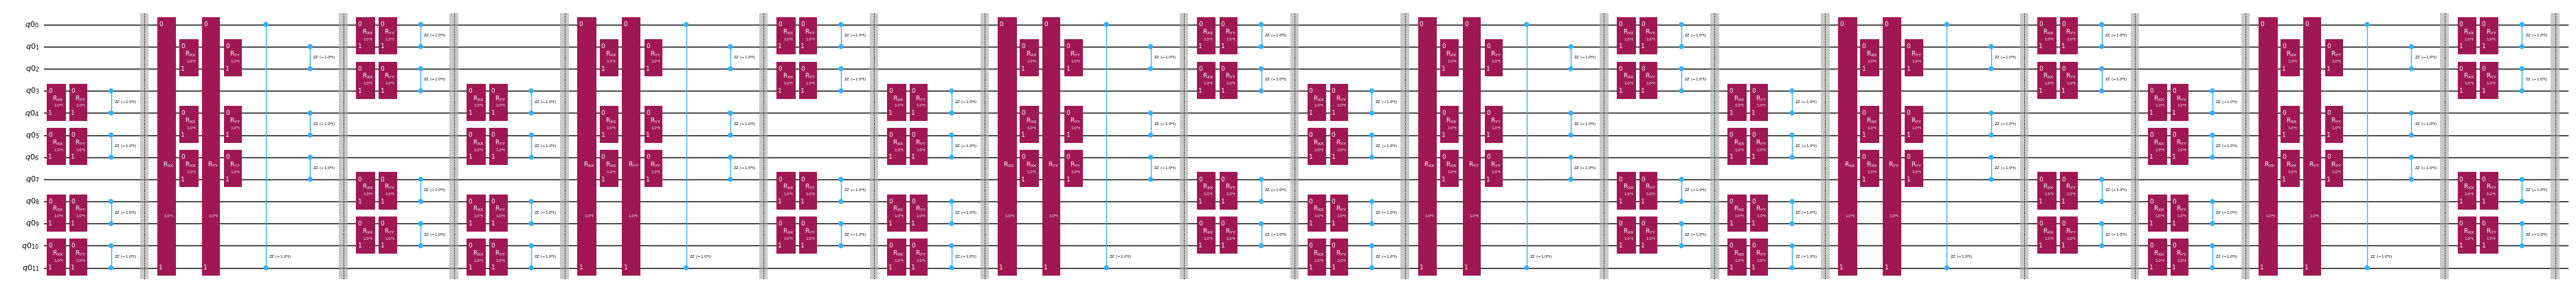

In [17]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, transpile
t = Parameter('t')

# Create instruction for rotation about XX+YY-ZZ:
Rxyz_circ = QuantumCircuit(2)
Rxyz_circ.rxx(J*t,0,1)
Rxyz_circ.ryy(J*t,0,1)
Rxyz_circ.rzz(g*t,0,1)
Rxyz_instr = Rxyz_circ.to_instruction(label='RXX+YY-ZZ')

# interaction_list = [[[i, i+1] for i in range(0, n_qubits-1, 2)], [[i, i+1] for i in range(1, n_qubits-1, 2)]] # linear chain
# interaction_list[1].append([0, n_qubits-1]) # periodic boundary conditions
colored_edges

qr = QuantumRegister(n_qubits)
trotter_step_circ = QuantumCircuit(qr)
for i, color in enumerate(sys_colored_edges):
    for interaction in color:
        trotter_step_circ.append(Rxyz_instr, interaction)
    trotter_step_circ.barrier()
reverse_trotter_step_circ = trotter_step_circ.reverse_ops()

qc_evol = QuantumCircuit(qr)
for step in range(trotter_order):
    if step % 2 == 0:
        qc_evol = qc_evol.compose(trotter_step_circ)
    else:
        # qc_evol = qc_evol.compose(reverse_trotter_step_circ)
        qc_evol = qc_evol.compose(trotter_step_circ)

qc_evol.decompose().draw('mpl', fold=-1, scale = 0.5)

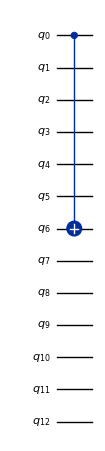

In [18]:
controlled_state_prep = QuantumCircuit(n_qubits + 1)
controlled_state_prep.cx(0,int(n_qubits/2))
controlled_state_prep.draw('mpl', fold=-1, scale=0.5)


controlled_state_prep.draw('mpl', fold=-1, scale=0.5)

In [19]:
# Parameters for the template circuits
dt_circ = dt/trotter_order
parameters = []
for idx_ket in range(1, krylov_dim):
    parameters.append(dt_circ*(idx_ket))



# Define a sweep over parameter values
params = np.vstack(parameters).T

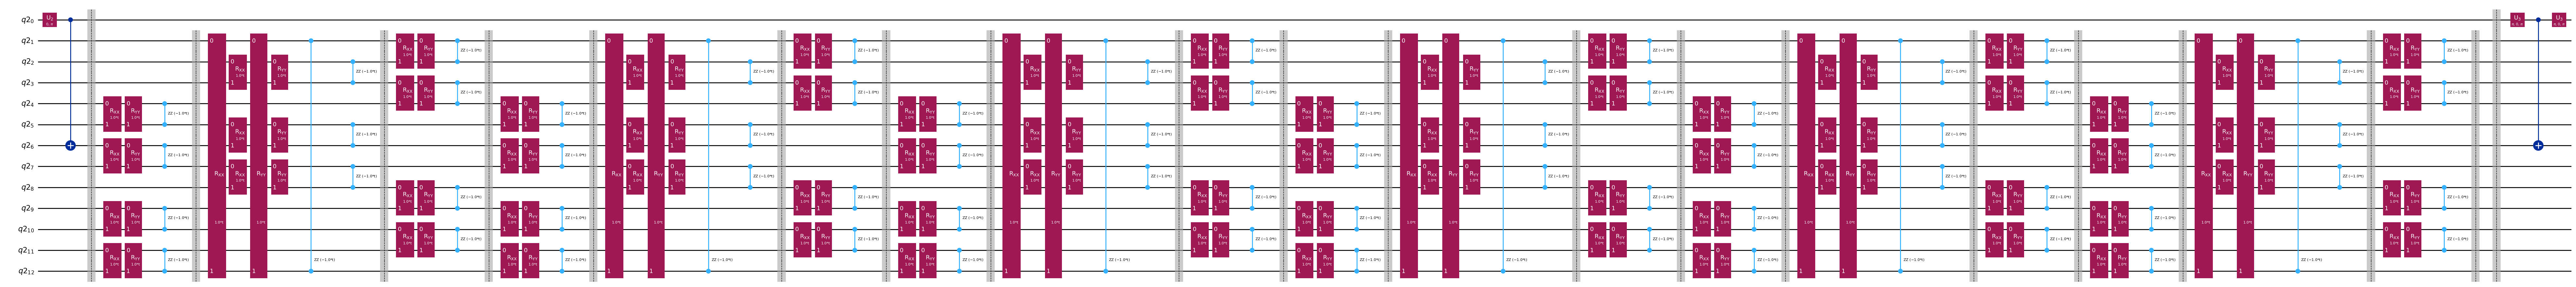

In [20]:
# Create hadamard test circuit
qr = QuantumRegister(n_qubits+1)
qc = QuantumCircuit(qr)
qc.h(0)
qc.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
qc.barrier()
qc.compose(qc_evol, list(range(1, n_qubits+1)), inplace=True)
qc.barrier()
qc.x(0)
qc.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc.x(0)

qc.decompose().draw('mpl', fold=-1)

In [21]:
from qiskit_aer import AerSimulator


backend = AerSimulator()

# Define observables to measure for S
observable_S_real = 'I'*(n_qubits) + 'X'
observable_S_imag = 'I'*(n_qubits) + 'Y'

observables_S = [[observable_S_real], [observable_S_imag]]


# Define observables to measure for H
# Hamiltonian terms to measure
observable_list = []
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    # print(pauli)
    observable_H_real = pauli[::-1].to_label() + 'X'
    observable_H_imag = pauli[::-1].to_label() + 'Y'
    observable_list.append([observable_H_real])
    observable_list.append([observable_H_imag])
observables_H = observable_list


pub = (qc.decompose(), observables_S + observables_H, params)



In [22]:
from qiskit.quantum_info import StabilizerState, Pauli



qc_cliff = qc.assign_parameters({t:0})

# observables_H_real_cliff = []
# observables_H_imag_cliff = []
# for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
#     # print(pauli)
#     observable_real = pauli[::-1].to_label() + 'X'
#     observable_imag = pauli[::-1].to_label() + 'Y'
#     observables_H_real_cliff.append(observable_real)
#     observables_H_imag_cliff.append(observable_imag)



# Get expectation values from experiment
S_expval_real = StabilizerState(qc_cliff).expectation_value(Pauli('I'*(n_qubits) + 'X'))
S_expval_imag = StabilizerState(qc_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Y'))

# Get expectation values
S_expval = S_expval_real + 1j*S_expval_imag

H_expval = 0
for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Get expectation values from experiment
    expval_real = StabilizerState(qc_cliff).expectation_value(Pauli(pauli[::-1].to_label() + 'X'))
    expval_imag = StabilizerState(qc_cliff).expectation_value(Pauli(pauli[::-1].to_label() + 'Y'))
    expval = expval_real + 1j*expval_imag


    # Fill-in matrix elements
    H_expval += coeff*expval


H_expval

(-8+0j)

In [23]:
# from pec_runtime.primitives import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

shots = 100000
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    job = estimator.run([pub], precision=1/np.sqrt(shots))

/var/folders/dk/j4n5f_1d3xs7m8bq81g9gfk80000gn/T/ipykernel_31218/1084987031.py:6: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)


In [24]:
results = job.result()[0]

In [25]:
prefactors = []
E0t_array = []
for i, circ in enumerate(iter(qc_evol.assign_parameters([(i*dt)/trotter_order]) for i in range(1, krylov_dim))):
    phase = 1.0
    E0t = 0
    for instruction in circ.data:
        if instruction.operation.name != 'swap' and instruction.operation.name != 'barrier':
            # All the non-swap gates are XX+YY+ZZ rotations, which add a phase to the all-zeros state.
            if instruction.operation.params:
                E0t += float(instruction.operation.params[0])
                # phase *= np.exp(1j*float(instruction.operation.params[0])/2)
                phase *= np.exp(-1j*float(instruction.operation.params[0])/2) # NY added, we need to `subtract` the E0 * t so minus sign
            # assert(float(instruction.operation.params[0]._symbol_expr) == i*dt/n_T_step)
    prefactors.append(phase)

In [26]:
import itertools
# Assemble S, the overlap matrix of dimension D:
S_first_row = np.zeros(krylov_dim, dtype=complex)
S_first_row[0] = 1+0j

# Add in ancilla-only measurements:
for i in range(krylov_dim-1):

    # Get expectation values from experiment
    expval_real = results.data.evs[0, i] # automatic extrapolated evs if ZNE is used
    expval_imag = results.data.evs[1, i] # automatic extrapolated evs if ZNE is used

    # Get expectation values
    expval = expval_real + 1j*expval_imag
    # Get the coefficients and expectation values corresponding to actual terms in the Hamiltonian (as opposed to the ancilla-only measurements).
    S_first_row[i+1] += prefactors[i]*expval

S_first_row_list =  S_first_row.tolist() #for saving purposes     
            
            
S_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        S_circ[j,i] = S_first_row[i-j]
    else:
        S_circ[j,i] = np.conj(S_first_row[j-i])

In [27]:
Matrix(S_circ)

Matrix([
[                                      1.0,    0.688285580034875 - 0.71144789613513*I, -0.0263614275504628 - 0.958987062385751*I,  -0.672934255995842 - 0.614829663324473*I,  -0.847831252791922 + 0.048502069146461*I,  -0.497856469555969 + 0.579848887682745*I,  0.0570048972450742 + 0.665974171287672*I,   0.441422076731412 + 0.361300732504389*I,   0.45032297391138 - 0.0524538549899136*I,   0.204894123884134 - 0.271614503046824*I],
[   0.688285580034875 + 0.71144789613513*I,                                       1.0,    0.688285580034875 - 0.71144789613513*I, -0.0263614275504628 - 0.958987062385751*I,  -0.672934255995842 - 0.614829663324473*I,  -0.847831252791922 + 0.048502069146461*I,  -0.497856469555969 + 0.579848887682745*I,  0.0570048972450742 + 0.665974171287672*I,   0.441422076731412 + 0.361300732504389*I,   0.45032297391138 - 0.0524538549899136*I],
[-0.0263614275504628 + 0.958987062385751*I,    0.688285580034875 + 0.71144789613513*I,                                       1.

In [28]:
import itertools
# Assemble S, the overlap matrix of dimension D:
H_first_row = np.zeros(krylov_dim, dtype=complex)
H_first_row[0] = H_expval

res_dict_sim = {i: {} for i in range(krylov_dim-1)}
for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Add in ancilla-only measurements:
    for i in range(krylov_dim-1):
        

        # Get expectation values from experiment
        expval_real = results.data.evs[2 + 2*obs_idx][i] # automatic extrapolated evs if ZNE is used
        expval_imag = results.data.evs[2 + 2*obs_idx + 1][i] # automatic extrapolated evs if ZNE is used

        res_dict_sim[i][(observables_S + observables_H)[2 + 2*obs_idx][0]] = expval_real
        res_dict_sim[i][(observables_S + observables_H)[2 + 2*obs_idx + 1][0]] = expval_imag

        # Get expectation values
        expval = expval_real + 1j*expval_imag
        # Get the coefficients and expectation values corresponding to actual terms in the Hamiltonian (as opposed to the ancilla-only measurements).
        H_first_row[i+1] += prefactors[i]*coeff*expval
        
H_first_row_list = H_first_row.tolist()           
            
H_eff_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ[j,i] = H_first_row[i-j]
    else:
        H_eff_circ[j,i] = np.conj(H_first_row[j-i])

In [29]:
from sympy import Matrix
Matrix(H_eff_circ)

Matrix([
[                                   -8.0,  -5.76606562600977 + 5.43831278944957*I, -0.506978464950533 + 7.69974020216236*I,   4.63012272778377 + 5.76291362003615*I,   6.81655127616562 + 1.11523492495053*I,    5.3210117019872 - 3.47087167543898*I,   1.52298721203421 - 5.49002986060878*I,  -2.14883929970941 - 4.57569209760654*I,  -3.92386729157093 - 1.78990933951431*I, -3.49572027274178 + 0.735599610471531*I],
[ -5.76606562600977 - 5.43831278944957*I,                                    -8.0,  -5.76606562600977 + 5.43831278944957*I, -0.506978464950533 + 7.69974020216236*I,   4.63012272778377 + 5.76291362003615*I,   6.81655127616562 + 1.11523492495053*I,    5.3210117019872 - 3.47087167543898*I,   1.52298721203421 - 5.49002986060878*I,  -2.14883929970941 - 4.57569209760654*I,  -3.92386729157093 - 1.78990933951431*I],
[-0.506978464950533 - 7.69974020216236*I,  -5.76606562600977 - 5.43831278944957*I,                                    -8.0,  -5.76606562600977 + 5.43831278944957*I, -0

In [30]:
gnd_en_circ_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ[:d, :d], S_circ[:d, :d], threshold=0.003)
    gnd_en_circ_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

The estimated ground state energy is:  [-8.]
The estimated ground state energy is:  [-10.6285897]
The estimated ground state energy is:  [-10.45132948]
The estimated ground state energy is:  [-10.77402964]
The estimated ground state energy is:  [-11.08446341]
The estimated ground state energy is:  [-12.10408464]
The estimated ground state energy is:  [-11.35151812]
The estimated ground state energy is:  [-24.48214843]
The estimated ground state energy is:  [-21.08944805]
The estimated ground state energy is:  [-13.17903401]


In [31]:
from qiskit.quantum_info import Statevector, Pauli


res_dict_id = {i:{} for i in range(krylov_dim-1)}
for i, param in enumerate(parameters):

    qc_t = qc.assign_parameters({t:param})

    for obs in observables_S + observables_H:
        res_dict_id[i][obs[0]] = Statevector(qc_t).expectation_value(Pauli(obs[0]))



## Exact Krylov

In [90]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp


# Make it sparse and calculate true GS
H_mat = H_op.to_matrix(sparse=True)
true_gse, true_gs = sp.sparse.linalg.eigsh(H_mat, which='SA', k=1)
true_gse = true_gse[0]


d = krylov_dim # Krylov dimension

# # start with computational state as reference state
# checkerboard_excitations = [l*r + i for r in range(w) for i in range(l) if i%2==r%2]
# v0 = np.zeros(2**n_qubits, dtype=complex)
# v0[sum([2**q for q in checkerboard_excitations])] = 1
particle_inds_ED = np.array(particle_inds) - 1
psi_sys = psi = tensor([zero if idx in particle_inds_ED else one for idx in range(lat.n_qubits)])
v0 = psi_sys.T


# Construct Krylov vectors
v = [v0.toarray()]
for i in range(d-1):
    ui = sp.sparse.linalg.expm_multiply(-1j*H_mat*dt, v[i])
    ui = ui/np.linalg.norm(ui)
    v.append(ui)

v = np.array(v).T

# Construct Krylov matrices
H_kry = np.conj(v[0]).T @ H_mat @ v[0]
S_kry = np.conj(v[0]).T @ v[0]


gnd_en_kry_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_kry_est = solve_regularized_gen_eig(H_kry[:d, :d], S_kry[:d, :d], threshold=0.003)
    gnd_en_kry_est_list.append(gnd_en_kry_est)
    print('The estimated ground state energy is: ', gnd_en_kry_est)

# # Look at all subspace dimensions up to d
# approx_gs_energies = []
# for _d in range(1,d+1):

# 	# Regularize by projecting onto good eigenspaces of S_kry
# 	s_vals, s_vecs = sp.linalg.eigh(S_kry[:_d,:_d])
# 	s_vecs = s_vecs.T
# 	reg_transform = [vec for val, vec in zip(s_vals, s_vecs) if val > _d * threshold_rescale * r]
# 	if reg_transform is []:
# 		raise AssertionError('WHOLE SUBSPACE ILL-CONDITIONED')
# 	reg_transform = np.array(reg_transform).T
# 	H_reg = reg_transform.T.conj() @ H_kry[:_d,:_d] @ reg_transform
# 	S_reg = reg_transform.T.conj() @ S_kry[:_d,:_d] @ reg_transform

# 	# Solve generalized eigenvalue problem
# 	vals, vecs = sp.linalg.eigh(H_reg, S_reg)

# 	approx_gs_energies.append(min(vals))

The estimated ground state energy is:  [-8.]
The estimated ground state energy is:  [-10.8141386]
The estimated ground state energy is:  [-10.79042494]
The estimated ground state energy is:  [-11.44791484]
The estimated ground state energy is:  [-11.4369287]
The estimated ground state energy is:  [-11.42316223]
The estimated ground state energy is:  [-11.40642427]
The estimated ground state energy is:  [-11.38650649]
The estimated ground state energy is:  [-11.66329469]
The estimated ground state energy is:  [-11.65450927]


## Benchmark against Exact Diagonalization

In [87]:
#Initialize state

zero, one = np.array([1,0]), np.array([0,1])
X,Y,Z,I= np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]]), np.eye(2)
H = np.sqrt(1/2)*np.array([[1,1],[1,-1]])

def tensor(op_list):
    op = op_list[0]
    for i in range(1, len(op_list)):
        op = spkron(op, op_list[i], format='csr')
    return op

edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1]]
l1_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==1]
l2_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==2]
l3_edges = [(k[0]+1, k[1]+1) for (k,v) in lat.couplings.items() if k[0] < k[1] and v==3]
colored_edges = [l1_edges, l2_edges, l3_edges]

particle_inds_ED = np.array(particle_inds) + 1
psi = tensor([zero if idx in particle_inds_ED else one for idx in range(lat.n_qubits + 1)])
psi = psi.T

In [33]:
#State prep

H_gate = tensor([H]+[I for _ in range(lat.n_qubits)])
psi = H_gate@psi
state_prep_gates = tensor([np.outer(zero,zero)]+[I for i in range(1,lat.n_qubits+1)]) + \
      tensor([np.outer(one,one)]+[I if i != particle_inds_ED[0] else X for i in range(1,lat.n_qubits+1)])
for n in range(1,len(particle_inds_ED)):
    state_prep_gates = (tensor([np.outer(zero,zero)]+[I for i in range(1,lat.n_qubits+1)]) + \
      tensor([np.outer(one,one)]+[I if i != particle_inds_ED[n] else X for i in range(1,lat.n_qubits+1)]))@state_prep_gates
psi = state_prep_gates@psi

In [35]:
#Build Trotter gates

trotter_gates = []
for l in range(3):
    layer_gates = []
    for e in colored_edges[l]:
        XX = tensor([I]+[X if i in e else I for i in range(1, lat.n_qubits+1)])
        YY = tensor([I]+[Y if i in e else I for i in range(1, lat.n_qubits+1)])
        ZZ = tensor([I]+[Z if i in e else I for i in range(1, lat.n_qubits+1)])
        layer_gates.append(sp_expm(-1j*(dt/trotter_order)*ZZ)@sp_expm(-1j*(dt/trotter_order)*YY)@sp_expm(-1j*(dt/trotter_order)*XX))
    trotter_gates.append(layer_gates)

/Users/mirko/opt/miniconda3/envs/krylov-1.0/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/mirko/opt/miniconda3/envs/krylov-1.0/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


In [36]:
colored_edges

[[(4, 5), (6, 7), (9, 10), (11, 12)],
 [(2, 3), (5, 6), (7, 8), (1, 12)],
 [(1, 2), (3, 4), (8, 9), (10, 11)]]

In [37]:
#Trotterized time-evolution

pre_measure_states = [psi.copy()]
for d in range(krylov_dim-1):
    for n in range(trotter_order):
        for l in range(3):
            for i in range(len(colored_edges[l])):
                psi = trotter_gates[l][i]@psi
    pre_measure_states.append(psi.copy())

In [38]:
#opposite control state prep circuit

inverse_state_prep_gates = tensor([np.outer(one,one)]+[I for i in range(1,lat.n_qubits+1)]) + \
      tensor([np.outer(zero,zero)]+[I if i != particle_inds_ED[0] else X for i in range(1,lat.n_qubits+1)])
for n in range(1,len(particle_inds_ED)):
    inverse_state_prep_gates = (tensor([np.outer(one,one)]+[I for i in range(1,lat.n_qubits+1)]) + \
      tensor([np.outer(zero,zero)]+[I if i != particle_inds_ED[n] else X for i in range(1,lat.n_qubits+1)]))@inverse_state_prep_gates
for d in range(krylov_dim):
      pre_measure_states[d] = inverse_state_prep_gates@pre_measure_states[d]

In [39]:
#Hamiltonian Pauli terms

X_terms, Y_terms, Z_terms = [],[],[]
X_terms_str, Y_terms_str, Z_terms_str = [],[],[]
all_coeffs = []
for pair in edges:
    X_terms.append([I if i not in pair else X for i in range(1, lat.n_qubits+1)])
    Y_terms.append([I if i not in pair else Y for i in range(1, lat.n_qubits+1)])
    Z_terms.append([I if i not in pair else Z for i in range(1, lat.n_qubits+1)])
    all_coeffs.append(J)
    all_coeffs.append(J)
    all_coeffs.append(g)

    X_terms_str.append(['I' if i not in pair else 'X' for i in range(1, lat.n_qubits+1)])
    Y_terms_str.append(['I' if i not in pair else 'Y' for i in range(1, lat.n_qubits+1)])
    Z_terms_str.append(['I' if i not in pair else 'Z' for i in range(1, lat.n_qubits+1)])
all_terms = X_terms + Y_terms + Z_terms
all_terms_str = X_terms_str + Y_terms_str + Z_terms_str

In [40]:
#Hamiltonian Pauli terms

op_H_real = []
op_H_imag = []
for op_list in all_terms:
    op_H_imag.append(tensor([Y]+op_list))
    op_H_real.append(tensor([X]+op_list))
op_S_real = tensor([X]+[I for _ in range(lat.n_qubits)])
op_S_imag = tensor([Y]+[I for _ in range(lat.n_qubits)])

op_H_real_str = []
op_H_imag_str = []
for op_list in all_terms_str:
    op_H_real_str.append(''.join(op_list+['X']))
    op_H_imag_str.append(''.join(op_list+['Y']))
op_S_real_str = ''.join(['I' for _ in range(lat.n_qubits)] + ['X'])
op_S_imag_str = ''.join(['I' for _ in range(lat.n_qubits)] + ['Y'])

In [41]:
res_dict_exact = {}
for d in range(krylov_dim):
    res_dict_exact[d] = {}
    for i in range(len(all_terms)):
        res_dict_exact[d][op_H_real_str[i]] = (pre_measure_states[d].conj().T@op_H_real[i]@pre_measure_states[d]).toarray()[0,0]
        res_dict_exact[d][op_H_imag_str[i]] = (pre_measure_states[d].conj().T@op_H_imag[i]@pre_measure_states[d]).toarray()[0,0]
    res_dict_exact[d][op_S_real_str] = (pre_measure_states[d].conj().T@op_S_real@pre_measure_states[d]).toarray()[0,0]
    res_dict_exact[d][op_S_imag_str] = (pre_measure_states[d].conj().T@op_S_imag@pre_measure_states[d]).toarray()[0,0]





In [42]:
#Build Toeplitz Krylov Matrices

H_krylov_row1 = np.zeros(krylov_dim, dtype=np.complex128)
S_krylov_row1 = np.zeros(krylov_dim, dtype=np.complex128)
for d in range(krylov_dim):
    for i in range(len(all_terms)):
        H_krylov_row1[d] += (pre_measure_states[d].conj().T@op_H_real[i]@pre_measure_states[d] \
            + 1j* pre_measure_states[d].conj().T@op_H_imag[i]@pre_measure_states[d]).toarray()[0,0]*all_coeffs[i]
    S_krylov_row1[d] = (pre_measure_states[d].conj().T@op_S_real@pre_measure_states[d] \
        + 1j* pre_measure_states[d].conj().T@op_S_imag@pre_measure_states[d]).toarray()[0,0]
    
H_ed = toeplitz(H_krylov_row1.conj())
S_ed = toeplitz(S_krylov_row1.conj())


In [44]:
evals_ed = solve_regularized_gen_eig(H_ed, S_ed, threshold=1e-2)
# evals_tn = solve_regularized_gen_eig(H_tn, S_tn, threshold=1e-8)

In [45]:
print(evals_ed)

[0.99288927]


## Exact calculation in subsector

In [50]:
# THIS FUNCTION CALCULATES THE PAULI MATRICES FOR EACH DIMENSION IN d_list, USING NOBU'S k-PARTICLE CODE
# Note that passing in vectors_kp is optional but if you already have it from the Krylov matrix calculation, it can save time.
from utils_k_particle import compute_pauli_matrices
from utils_k_particle import get_indexes_for_m_particles, k_particle_excitation, simulate_unitary_kparticle_from_interaction_list

fixed_control = 0
excitations = [int(n_qubits/2)]
H = H_op     

k = len(excitations)
indices = get_indexes_for_m_particles(n_qubits, k)

initial_state_kp = k_particle_excitation(n_qubits, excitations, indices)
vectors_kp = [simulate_unitary_kparticle_from_interaction_list(sys_colored_edges, initial_state_kp, n_qubits, k, trotter_order, param = (i*dt)/trotter_order, as_sparse = True) for i in range(krylov_dim)]

all_exp_vals, vectors_kp = compute_pauli_matrices(n_qubits, fixed_control, excitations, H, sys_colored_edges, trotter_order, dt, list(range(krylov_dim)), vectors_kp)



H_first_row_exact = np.zeros(krylov_dim, dtype=complex)
prefactors_exact = [1+0j] + prefactors
for i, expvals_dict in enumerate(all_exp_vals):

    for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
        # Get expectation values from experiment
        obs = observables_H[obs_idx][0]
        expval_real = expvals_dict[obs]
        expval_imag = expvals_dict[obs]


        expval = expval_real + 1j*expval_imag

        H_first_row_exact[i] += prefactors_exact[i]*coeff*expval



H_first_row_exact_list = H_first_row_exact.tolist()           
            
H_eff_circ_exact = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ_exact[j,i] = H_first_row_exact[i-j]
    else:
        H_eff_circ_exact[j,i] = np.conj(H_first_row_exact[j-i])

## Compare Paulis

In [54]:
idx = 2
for pauli in res_dict_sim[idx].keys():
    # print(pauli)
    if pauli in res_dict_tn[idx].keys():
        print(pauli, res_dict_exact[idx][pauli], res_dict_tn[idx][pauli], all_exp_vals[idx][pauli], res_dict_sim[idx][pauli] )

IIIIIIIIIIZZX (0.5896238601335273+0j) 0.5896238601335164 -0.39988618929067854 0.7531624683753162
IIIIIIIIIIZZY (0.607099460550353+0j) 0.6070994605503303 -0.8732512789542389 -0.5140248597514024
IIIIIIIIIZZIX (0.5896238601335273+0j) 0.5896238601335164 -0.39988618929067854 0.7531624683753162
IIIIIIIIIZZIY (0.607099460550353+0j) 0.6070994605503303 -0.8732512789542389 -0.5140248597514024
IIIIIIIIZZIIX (0.5896238601335273+0j) 0.5896238601335164 -0.39988618929067854 0.7531824681753182
IIIIIIIIZZIIY (0.607099460550353+0j) 0.6070994605503303 -0.8732512789542389 -0.5140848591514084
IIIIIIIZZIIIX (0.5896238601335273+0j) 0.5896238601335163 -0.39988618929067854 0.7533624663753362
IIIIIIIZZIIIY (0.607099460550353+0j) 0.6070994605503299 -0.8732512789542389 -0.5146648533514665
IIIIIIZZIIIIX (-0.5896238601335273+0j) -0.5896238601335163 -0.39988618929067854 -0.7529424705752943
IIIIIIZZIIIIY (-0.607099460550353+0j) -0.60709946055033 -0.8732512789542389 0.5131848681513185
IIIIIZZIIIIIX (-0.589623860133527